# Physics Informed Neural Networks (PINN)
> For the Fall 2024 course: *Machine Learning in Physics*<br>
> Created: Aug. 14, 2024 Harrison B. Prosper

## Introduction
Most differential equations cannot be solved exactly. Therefore, over the centuries numerical methods have been devised to solve these equations approximately. A relatively recent numerical approach called **physics-informed neural networks** (PINN) formulates the solution of a differential equation as an optimization problem in which the approximate solution is modeled using one or more neural networks. For an excellent introduction, I recommend the lectures by Bob Moseley[1]. For a thorough review, see Ref.[2]. The approach is feasible thanks to **automatic differentiation**, which enables the derivatives that enter the objective function to be computed *exactly*.

The term physics-informed neural network is clearly a misnomer because the method can be applied to *any* differential equation, not only the ones that occur in physics! 

In this tutorial we consider the example presented by Bob Moseley in the lecture cited above, namely, the solution $x(t) \in \mathbb{R}$, $t \in \mathbb{R}^+$, of the ordinary differential equation (ODE)
\begin{align}
   \frac{d^2 x}{dt^2} + 2 \lambda \frac{d x}{ dt } + \omega_0^2 x = 0,
\end{align}
describing a 1D **damped harmomic oscillator**, where 
\begin{align}
    \lambda & = \frac{c}{m} \quad\text{and}\\
    \omega_0 & = \sqrt{\frac{k}{m}}
\end{align}
are the characteristic decay rate of the oscillation amplitude and the characteristic angular frequency, respectively. (We follow the notation in Ref.[3], but note in Bob Moseley's lecture $\lambda \equiv \delta$ and $x(t) \equiv u(t)$.) The quantity $m$ is the mass of the oscillating object, $k$ is the spring constant and $c$ is called the *viscous damping coefficient*[3].  

### Exact Solution
It is almost always a good idea to try to simplify a differential equation before solving it. We can simplify the ODE by dividing throughout by $\omega_0^2$ and defining the dimensionless quantities $z = \omega_0 \, t$ and $\zeta = \lambda /\omega_0 $; $\zeta$ is called the *damping ratio* and is proportional to the ratio of the natural oscillation and damping timescales. With these changes the ODE becomes
\begin{align}
  \frac{d^2 x}{d z^2}  +  2 \zeta \frac{d x}{dz} + x = 0 ,
\end{align}
which shows that the damped harmonic oscillator is governed by the single parameter $\zeta$. To obtain a particular solution of the equation we must specify initial conditions
\begin{align}
    x(0) & = x_0, \\
    \left. \frac{d x}{dz} \right|_{z=0} & = v_0 . 
\end{align}
Since this is a linear equation, we can try a solution of the form 
\begin{align}
    x(z) & = A \exp(i q z + \phi),
\end{align}
where $A$ and $\phi$ are constants to be determined by the initial conditions and where it is understood that we'll take the real part of $x(z)$ at the end. One finds $q = i \zeta \pm \sqrt{1 - \zeta^2}$. Taking the positive value of $\sqrt{1 - \zeta^2}$ and restricting to the (underdamped) condition $\zeta < 1$ the exact solution is given by
\begin{align}
    x(z) & = A \exp(-\zeta z) \, \cos\left(z \sqrt{1-\zeta^2} + \phi\right)  \quad\text{and} \\
    \phi & = \arctan\left(-\frac{(\zeta + v_0 / x_0)}{\sqrt{1 - \zeta^2}}\right), \quad A = \frac{x_0}{\cos\phi} .
\end{align}
In terms of the original parameters, 
 the exact solution of the ODE for $\zeta < 1$, that is, $\omega_0 > \lambda$, is 
\begin{align}
    x(t) & = A \exp(-\lambda t) \, \cos(\omega \, t + \phi), \quad\text{with } \omega = \sqrt{\omega_0^2 - \lambda^2} \quad\text{and} \\
    \phi & = \arctan(-(\lambda + v_0 / x_0) \, / \, \omega), \quad A = x_0 \, / \, \cos\phi , 
\end{align}
with $v_0$ now defined to be $v_0 = dx(0) / dt$ rather than $dx(0) / dz$.

## Physics-Informed Neural Networks
Automatic differentiation is the key technology that has enabled the use of increasingly complex models in contemporary machine learning. The same technology can be used to compute derivatives with respect to the inputs of a model. However, when the computation graph over the model parameters is extended to incorporate derivatives the model output with respect to its inputs, this can lead to an explosion in the size of the graph, which makes solving differential equations through this method considerably slower than algorithms that use finite differences. 

But if we condition the solution on the initial conditions $x_0$ and $v_0$ the high cost of finding the solutions using stochastic gradient descent for a *subset*, $S \subset \mathbb{R}^2$, of initial conditions is *amortized* over the subsequent rapid application of the PINN for any initial condition within $S$. In effect, the PINN approximates an *infinite* class of of solutions each indexed by the parameters $(x_0, v_0)$ that define the initial conditions. Furthermore, the physics parameters of the problem, here $\zeta$, can be included in the subset: $(x_0, v_0, \zeta) \in S \subset \mathbb{R}^3)$, thereby greatly extending the class of solutions. In a finite-difference approach for solving a differential equation, a different calculation is needed for each set of initial (and/or boundary) conditions and physics parameters. A PINN conditioned on the initial conditions is sometimes called a **conditioned PINN** (CPINN).  One of the nice features of PINNs is that their solutions can be checked explicitly at a few selected parameter points by comparing PINN solutions with solutions obtained using finite-difference methods.

The PINN approach applied to the damped harmonic oscillator entails solving the differential equation by minimizing the following empirical risk, or objective, function
\begin{align}
    O(\theta) & = \frac{1}{N} \sum_{i=1}^N \left(  \frac{d^2x_i}{dz_i^2} + 2 \zeta \frac{dx_i}{dz_i} + x_i \right)^2, \quad\quad
    x_i  \equiv x(z_i) .
\end{align}
The $z_i$ are called **collocation points**[1,2]. In the standard PINN approach, additional terms are added to incorporate the initial and/or boundary conditions and any additional data that constrains the solution. But in this tutorial, we have no additional data and we choose to incorporate the initial conditions explicitly using the *ansatz*
\begin{align}
    x(z)  & = \frac{x_0 + z \, v_0 + z^2 \, g(z, x_0, v_0, \zeta; \theta)}{1+z^2} ,
\end{align}
where $g(z, x_0, v_0, \zeta; \theta)$ is a deep neural network with free network parameters $\theta$. This ansatz has the property that $x(z) \rightarrow g(z,\cdots)$ and $dx/dz \rightarrow dg(z,\cdots)/dz$ as $z \rightarrow \infty$. 
Defining the point $p = (z, x_0, v_0, \zeta)$, our goal is to find a *continuous* set of solutions in the domain $$p \in [0, 20] \otimes [-1, 1] \otimes [-2, 2] \otimes [0, 0.5] \subset \mathbb{R}^4.$$

### References
  1. B. Moseley, see, for example, https://www.youtube.com/watch?v=IDIv92Z6Qvc.
  2. S. Cuomo et al., *Scientific Machine Learning through Physics-Informed Neural Networks: Where we are and What's next*, https://doi.org/10.48550/arXiv.2201.05624.
  3. https://en.wikipedia.org/wiki/Harmonic_oscillator

In [1]:
# standard system modules
import os, sys
sys.path.append('../../python')

# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np

# standard module for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn

# needed to generate Sobol sequences of points (quasi-random sampling)
# in R^4
from scipy.stats import qmc

# a simple time left function.
# to monitor the training do
# python monitor_losses.py losses.csv
from lossmonitor import TimeLeft

# update fonts
FONTSIZE = 10
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device: {str(device):4s}')

Available device: cpu 


## Exact solution
\begin{align}
    x(z) & = A \exp(-\zeta z) \, \cos\left(z \sqrt{1-\zeta^2} + \phi\right)  \quad\text{and} \\
    A & = \frac{x_0}{\cos\phi}, \quad \phi = \arctan\left[-\frac{(\zeta + v_0 / x_0)}{\sqrt{1 - \zeta^2}}\right].
\end{align}

In [22]:
def exact_solution(z, x0, v0, zeta):
    assert zeta > 0
    assert zeta < 1
    a = np.sqrt(1 - zeta**2)
    phi = np.arctan(-(zeta + v0/x0)/a)
    A = x0 / np.cos(phi)
    x = A * torch.exp(-zeta*z) * torch.cos(z*a + phi)
    return x

## Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to decide 1) whether the fit is reasonable (e.g., the model has not been overfitted), 2) decide which of several models is the best and 3) tune model hyperparameters.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of the fitted model.

The validation set will be some small fraction of the training set and will be used to decide when to stop the training.

## Generate data
Here we generate a quasi-random set of points, $p$, in $S_z \otimes S \subset \mathbb{R}^4$, where the set $S_z = [0, 20]$ with $z \in S_z$. Quasi-random sampling disributes points more evenly than uniform random sampling.

In [23]:
def sobol_sequence(D, N, lower, upper):
    # D: dimension of input space
    # N: power, with number of points = 2^N
    
    # generate 2^N points in a D-dimensional unit hypercube
    # and scramble the order in which they have been generated.
    sampler= qmc.Sobol(d=D, scramble=True)
    sample = sampler.random_base2(m=N)

    # scale from the unit hypercube to the hyperrectangle
    # that defines p in (z, x0, v0, zeta)
    sample = qmc.scale(sample, lower, upper)

    # convert to torch tensor of float32
    sample = torch.Tensor(sample)
    return sample

# -----------------------------------------------------------
# CONSTANTS
# -----------------------------------------------------------
LOSS_FILE     = 'losses.csv'   # average losses saved here
PARAMS_FILE   = 'model.pth'    # model parameters saved here
PLOT_FILE     = 'results.png'
TIMELEFT_FILE = 'timeleft.txt' # time left to training completion

# define domain of PINN
#           z,  x0,  v0, zeta
LOWER = [ 0.0,-1.0,-2.0, 0.0]
UPPER = [20.0, 1.0, 2.0, 0.5]
SCALE = [20.0, 1.0, 2.0, 1.0]  # see Solution class below

# -----------------------------------------------------------
# DATA
# -----------------------------------------------------------
# we'll be computing dx/dp so we need to alert PyTorch of this.
# also remember to send tensor to the computational device, which
# could be a GPU.
N = 18
X = sobol_sequence(len(LOWER), N, LOWER, UPPER).requires_grad_(True).to(device)

X.shape

torch.Size([262144, 4])

In [5]:
# number of training points
ntrain = min(250000, len(X))

# number of validation points (used during training)
nvalid = 5000

i = 0; j= i + ntrain
train_X = X[i:j]

i += ntrain; j = i + nvalid
valid_X = X[i:j]

i += nvalid
test_X = X[i:]

train_X.shape, valid_X.shape, test_X.shape

(torch.Size([250000, 4]), torch.Size([5000, 4]), torch.Size([7144, 4]))

## Define a fully-connected neural network

### $\texttt{SiLU}(x)$

$\text{silu}(x) = x \, \sigma(x), \text{where } \sigma(x) \text{ is the logistic sigmoid.}$

In [24]:
class Sin(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.sin(x)
        
class FCN(nn.Module):
    def __init__(self, n_input, n_hidden, n_width, 
                 nonlinearity=nn.SiLU):
        
        super().__init__()
        
        self.input = nn.Sequential(nn.Linear(n_input, n_width), nonlinearity())

        cmd  = 'nn.Sequential('
        cmd += ', '.join(['nn.Linear(n_width, n_width), nonlinearity()' 
                          for _ in range(n_hidden)])
        cmd += ')'
        self.hidden = eval(cmd)
        
        self.output = nn.Linear(n_width, 1)

    def forward(self, x):
        x = self.input(x)
        x = self.hidden(x)
        x = self.output(x)       
        return x

## Model solution ansatz
We incorporate the initial conditions $x_0, v_0$ explicitly using the following solution ansatz
\begin{align}
    x(z)  & = \frac{x_0 + z \, v_0 + z^2 \, g(z, p; \theta)}{1+z^2}, \quad\text{with derivative}\\
    \frac{dx(z)}{dz} & = \frac{-2 z \, x_0 + (1-z^2) \, v_0 + 2z \, g(z, p;\theta)}{(1+z^2)^2} +  \frac{z^2}{1+z^2} \, \frac{dg(z, p;\theta)}{dz},
\end{align}
where $g(z, p; \theta)$ is a deep neural network with network parameters $\theta$ and $p = (z, x_0, v_0, \zeta)$ are its inputs. This ansatz satisfies the conditions $x \rightarrow g$ and $dx/dz \rightarrow dg/dz$ as $z \rightarrow \infty$.

In [7]:
# This class inherits the properties of nn.Module
class Solution(nn.Module):
    
    def __init__(self, NN, scale):

        # remember to initialize base (that is, parent) class
        super().__init__()

        # cache neural network and send to computational device
        self.g = NN.to(device)  
        
        # "scale" is needed to ensure that the inputs to the neural network 
        # are of order 1. 
        # unsqueeze(dim=0) changes the shape of the tensor as follows: (4) => (1, 4).
        # use register_buffer to tell PyTorch to save "scale" when the NN
        # parameters as saved.
        self.register_buffer('scale', torch.tensor(scale).unsqueeze(dim=0))

    def save(self, dictfile):
        # save parameters of neural network to file "dictfile"
        torch.save(self.g.state_dict(), dictfile)

    def load(self, dictfile):
        # set NN to evaluation model and load parameters 
        # of neural network from "dictfile"
        self.g.eval()
        self.g.load_state_dict(torch.load(dictfile))

    def forward(self, p):
        # compute ansatz
        # --------------
        
        # p = (z, x0, v0, zeta)
        # get z = omega_0 * t, x0 = x(0) and v0 = dx(0)/dz
        z  = p[:, 0].view(-1, 1)
        x0 = p[:, 1].view(-1, 1)
        v0 = p[:, 2].view(-1, 1)
    
        # scale inputs to neural networks
        # so that they are of O(1)
        p_scaled = p / self.scale

        zz = z**2
        x  = (x0 + z * v0 + zz * self.g(p_scaled)) / (1 + zz)

        return x

## Model objective function
\begin{align}
    \frac{d^2x}{dz^2} + 2 \zeta \frac{dx}{dz} + x & = 0.
\end{align}

In [8]:
class Objective(nn.Module):

    def __init__(self, solution):
        super().__init__() 
        # cache solution within objective object
        self.solution = solution

    def eval(self):
        self.solution.eval()

    def train(self):
        self.solution.train()

    def save(self, paramsfile):
        self.solution.save(paramsfile)
        
    def forward(self, p):
        # p = (z, x0, v0, zeta)
        
        if len(p.shape) < 2:
            p = p.unsqueeze(dim=0) # this changes tensor shape: (-1) => (1, -1)

        # x(z)
        x = self.solution(p)
        
        # compute dx/dp = (dx/dz, dx/dx0, dx/dv0, dx/dzeta). this is
        # clearly overkill because we need only dx/dz. there is a way
        # to avoid this, but for now let's keep things simple.
        #
        # Note: autograd.grad computes the gradient of scalars, but since
        # x(z) is generally a batch of scalars with shape (batch-size, 1), 
        # we need to tell autograd.grad to apply the gradient operator to 
        # every scalar in the batch. We do this by passing autograd.grad a 
        # tensor of shape (batch-size, 1). It is also necessary to create 
        # the computation graph for this operation. Finally, we take the 
        # zeroth element of the returned object because autograd.grad 
        # returns a tuple.
        
        dxdp = torch.autograd.grad(x, p, 
                                   torch.ones_like(x), 
                                   create_graph=True)[0]

        # pick off dx/dz and make sure its shape is correct
        
        dxdz = dxdp[:, 0].view(-1, 1)

        # now compute d/dp (dx/dz), that is, (d/dz, d/dx0, d/dv0, d/dzeta) dx/dz.
        # in other words: d2x/dz2, d2x/dx0dz, d2x/dv0dz, d2x/dzetadz.
        # again, we're doing a lot more work than is necessary since we care only
        # about d2x/dz2, but let's keep things simple.
        
        d2xdp2 = torch.autograd.grad(dxdz, p, 
                                     torch.ones_like(dxdz), 
                                     create_graph=True)[0]

        # pick off d2x/dz2 and make sure it's the tensor shape is correct. 
        
        d2xdz2 = d2xdp2[:, 0].view(-1, 1)

        # pick off zeta and make sure it's also a batch of scalars.
        
        zeta = p[:, -1].view(-1, 1)

        # compute loss function

        loss = d2xdz2 + 2*zeta*dxdz + x

        # compute empirical risk (i.e., objective) function
        R = torch.mean(loss**2)
        
        return R

In [9]:
def number_of_parameters(model):
    return sum(param.numel() for param in model.parameters() if param.requires_grad)

def get_random_batch(x, batch_size):
    indices = torch.randint(0, len(x)-1, size=(batch_size,))
    return x[indices]

## Define solver

In [10]:
def solve(objective, optimizer, getbatch, train_X, valid_X, batch_size,
          number_iterations,
          lossfile=LOSS_FILE,
          timeleftfile=TIMELEFT_FILE,
          paramsfile=PARAMS_FILE,
          step=100):

    # number of validation data
    
    nvalid = len(valid_X)

    losswriter = lm.LossWriter(objective, number_iterations, 
                               lossfile, timeleftfile, paramsfile, 
                               step)

    # -------------------
    # enter training loop
    # -------------------
    
    for ii in range(number_iterations):
        
        optimizer.zero_grad()   # clear previous gradients
        
        # set mode to training so that training-specific 
        # operations such as dropout, etc., are enabled.
        
        objective.train()
    
        # get a batch of data 
        
        X = getbatch(train_X, batch_size)     

        y = objective(X)         # compute objective with current model parameters

        y.backward()             # compute gradients 
        
        optimizer.step()         # move one step in average loss landscape

        # i'm alive printout
        
        if (ii % step == 0) and (ii > 0):

            # place model in evaluation mode
            
            objective.eval()
            
            # compute value of objective function using first "n_valid" training 
            # data and detach result from computational graph
            
            t_loss = objective(train_X[:nvalid]).detach() 

            # compute value of objective function using "n_valid" validation data
            # and detach result from computational graph
            
            v_loss = objective(valid_X).detach()

            # update loss file
            
            losswriter(ii, t_loss, v_loss)

    print()      
    return 

## Instantiate solution and objective

In [11]:
fcn  = FCN(n_input=4, n_hidden=4, n_width=32, 
          nonlinearity=Sin).to(device)

soln = Solution(fcn, SCALE).to(device)

objective = Objective(soln).to(device)

number_of_parameters(fcn), objective

(4417,
 Objective(
   (solution): Solution(
     (g): FCN(
       (input): Sequential(
         (0): Linear(in_features=4, out_features=32, bias=True)
         (1): Sin()
       )
       (hidden): Sequential(
         (0): Linear(in_features=32, out_features=32, bias=True)
         (1): Sin()
         (2): Linear(in_features=32, out_features=32, bias=True)
         (3): Sin()
         (4): Linear(in_features=32, out_features=32, bias=True)
         (5): Sin()
         (6): Linear(in_features=32, out_features=32, bias=True)
         (7): Sin()
       )
       (output): Linear(in_features=32, out_features=1, bias=True)
     )
   )
 ))

## Train!

If $\texttt{niterations}$ is the number of iterations, $\texttt{ntrain}$ the training sample size, and $\texttt{nbatch}$ the batch size, the effective number of epochs, $\texttt{nepochs}$, is given by
$$\texttt{nepochs} = \texttt{niterations} \times \texttt{nbatch} / \texttt{ntrain}$$

In [12]:
loss_file = LOSS_FILE
timeleft_file = TIMELEFT_FILE
params_file = PARAMS_FILE

niterations = 150001
nbatch = 200 
step = 100
learning_rate = 5.0e-4

optimizer = torch.optim.Adam(objective.parameters(), lr=learning_rate) 

In [13]:
nepochs = niterations * nbatch / ntrain
print(f'number of epochs: {round(nepochs):d}')

number of epochs: 120


In [14]:
DELETE_LOSS_FILE = True

if DELETE_LOSS_FILE:
    os.system(f'rm -f {loss_file:s}')

solve(objective, optimizer, get_random_batch,
            train_X, valid_X, nbatch, niterations,
            loss_file, timeleft_file, params_file, step)

    150001|100.00%|00:13:28/00:00:00| 185.5 it/s|      149900|  0.00003393|  0.00003249|



## Plot solutions

In [15]:
def get_data(test, K=12, 
             zmin=LOWER[0], zmax=UPPER[0], nz=201, 
             paramsfile=PARAMS_FILE):

    # generate random parameter points

    X0, V0, ZETA = test[:, 1][:K], test[:, 2][:K], test[:, 3][:K] 

    # load model with smallest average loss (aka, empirical risk, 
    # objective function value) over the validation set
    
    soln.load(paramsfile)

    # loop over parameter points
    
    data = []
    
    for i, (x0, v0, zeta) in enumerate(zip(X0, V0, ZETA)):
        
        print(f'\r{i:5d}', end='')

        # generate equally-spaced points in z; make sure shape is correct
        # so that z, x0, v0, zeta can be concatenated correctly
        
        z = torch.linspace(zmin, zmax, nz).view(-1, 1)
 
        # we could be running on a GPU, so detach from computation graph 
        # and send to CPU explicitly

        z0 = z.detach().cpu().numpy()
        x0 = x0.detach().cpu()
        v0 = v0.detach().cpu()
        zeta = zeta.detach().cpu()
        
        exact = exact_solution(z0, x0, v0, zeta)

        # compute approximate solution
        
        X = [z, 
             x0*torch.ones_like(z),
             v0*torch.ones_like(z), 
             zeta*torch.ones_like(z)]

        # concatenate horizontally and send to computational device
        
        X = torch.cat(X, dim=1).to(device)

        approx = soln(X)

        # detach from computation graphs, send to CPU 
        # and convert to numpy array
 
        z = z.squeeze().detach().cpu().numpy()
        exact = exact.squeeze().detach().cpu().numpy() 
        approx = approx.squeeze().detach().cpu().numpy()
        
        # cache results
        
        data.append([z, exact, approx, x0, v0, zeta])
        
    print()
    return data

data = get_data(test_X)

   11


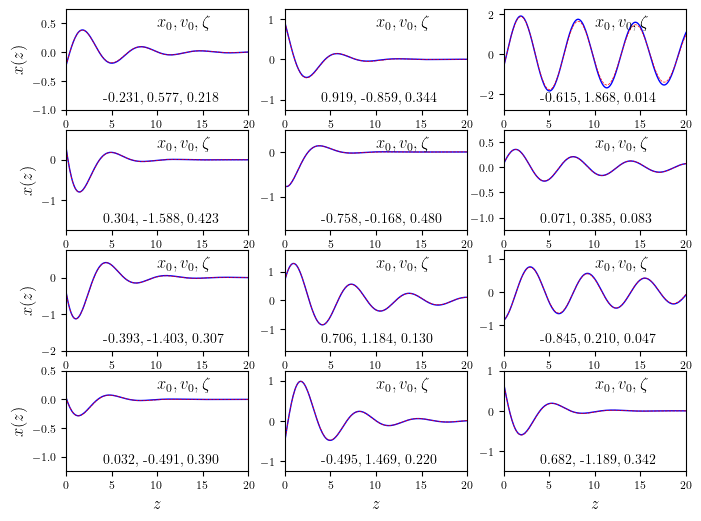

In [21]:
def plot_results(data, 
                 xmin=LOWER[0],  xmax=UPPER[0],
                 filename=PLOT_FILE,
                 fgsize=(8, 6), 
                 ftsize=14):

    plt.rcParams.update({'font.size': 10})

    # work out number of columns and number of plots
    ncols = 3
    nrows = len(data) // ncols
    ndata = nrows * ncols

    fgsize= (3*ncols, 2*nrows)
    
    # create an empty figure
    fig = plt.figure(figsize=fgsize)
    fig.tight_layout()

    for i, (z, exact, approx, x0, v0, zeta) in enumerate(data):

        index = i+1
        ax  = fig.add_subplot(nrows, ncols, index)
        
        # setup x-axis
        ax.set_xlim(xmin, xmax)
        
        if i > (nrows-1) * ncols-1:
            ax.set_xlabel(r'$z$', fontsize=ftsize)
        
        if i % ncols == 0:
            ax.set_ylabel(r'$x(z)$', fontsize=ftsize)

        # annotate plot
        dy = 0.25
        ymin = exact.min()
        n = int(np.abs(ymin)/dy)+4
        ymin = np.sign(ymin)*n*dy

        ymax = exact.max()
        n = int(np.abs(ymax)/dy)+2
        ymax = np.sign(ymax)*n*dy
        ax.set_ylim(ymin, ymax)

        xpos = xmin + 0.20 * (xmax-xmin)
        ypos = ymin + 0.30 * (ymax-ymin)
        ystep= (ymax-ymin)/5
        
        ax.text(xpos, ypos, r'$x_0, v_0, \zeta$', fontsize=14); ypos -= ystep
        ax.text(xpos, ypos, '%8.3f,%8.3f,%8.3f' % (x0, v0, zeta))

        ax.plot(z, exact,  color='blue', linestyle='solid', linewidth=1.0)
        ax.plot(z, approx, color='red', linestyle='dashed', linewidth=0.5)
        
    plt.savefig(filename)

plot_results(data)